# Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def calibrate_camera():
    
    files = glob.glob('camera_cal/calibration*.jpg')
    checkerboardsize = (9,6)
    
    h_count,v_count = checkerboardsize
    
    objp = np.zeros((v_count*h_count,3), np.float32)
    objp[:,:2] = np.mgrid[0:h_count, 0:v_count].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    
    for idx, fname in enumerate(files):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (h_count,v_count), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    image = cv2.imread(files[0])
    image_size = (image.shape[1], image.shape[0])
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size,None,None)

    return mtx, dist

cameraMatrix, distortionCoefficients = calibrate_camera()

def undistort(image):
  
    dst = cv2.undistort(
        image, 
        cameraMatrix, 
        distortionCoefficients, 
        None, 
        cameraMatrix)
    
    return dst


def test_undistort(file):
    
    img = cv2.imread(file)
    dst = undistort(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    

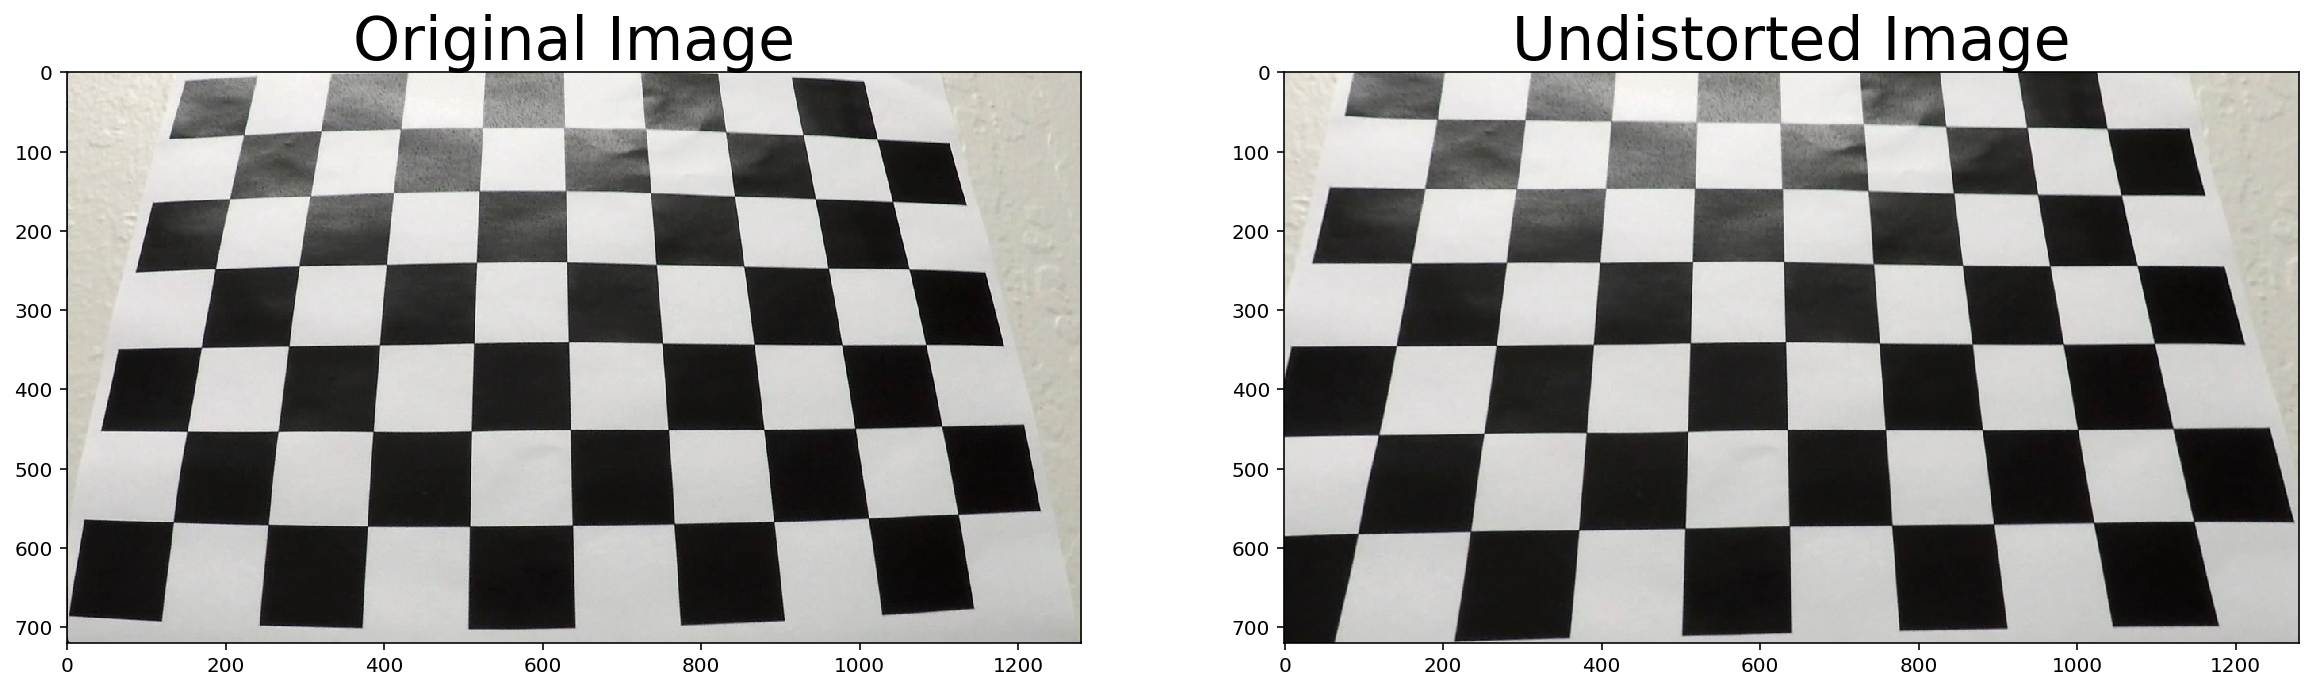

In [2]:
test_undistort('camera_cal/calibration3.jpg')

# Perspective Transform

In [184]:
def perspective_transforms():
    
    src = np.float32([
        [592,450], #top_left
        [686,450], #top_right
        [1074,693], #bottom_right
        [231,693] #bottom_left
        ])

    dst = np.float32([
        [250,0], #top_left
        [1080,0], #top_right
        [1080,678], #bottom_right
        [250,678] #bottom_left
        ])  
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

TransformMatrix,InverseTransformMatrix = perspective_transforms()

def transform(image):
    result = cv2.warpPerspective(image, TransformMatrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    return result

def reverse(image):
    result = cv2.warpPerspective(image, InverseTransformMatrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    return result


def test_transform(file):
    
    img = cv2.imread(file)
  
    img = undistort(img)
    
    warped = transform(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped)
    ax2.set_title('Warped Image', fontsize=30) 
    plt.imshow(warped)
    

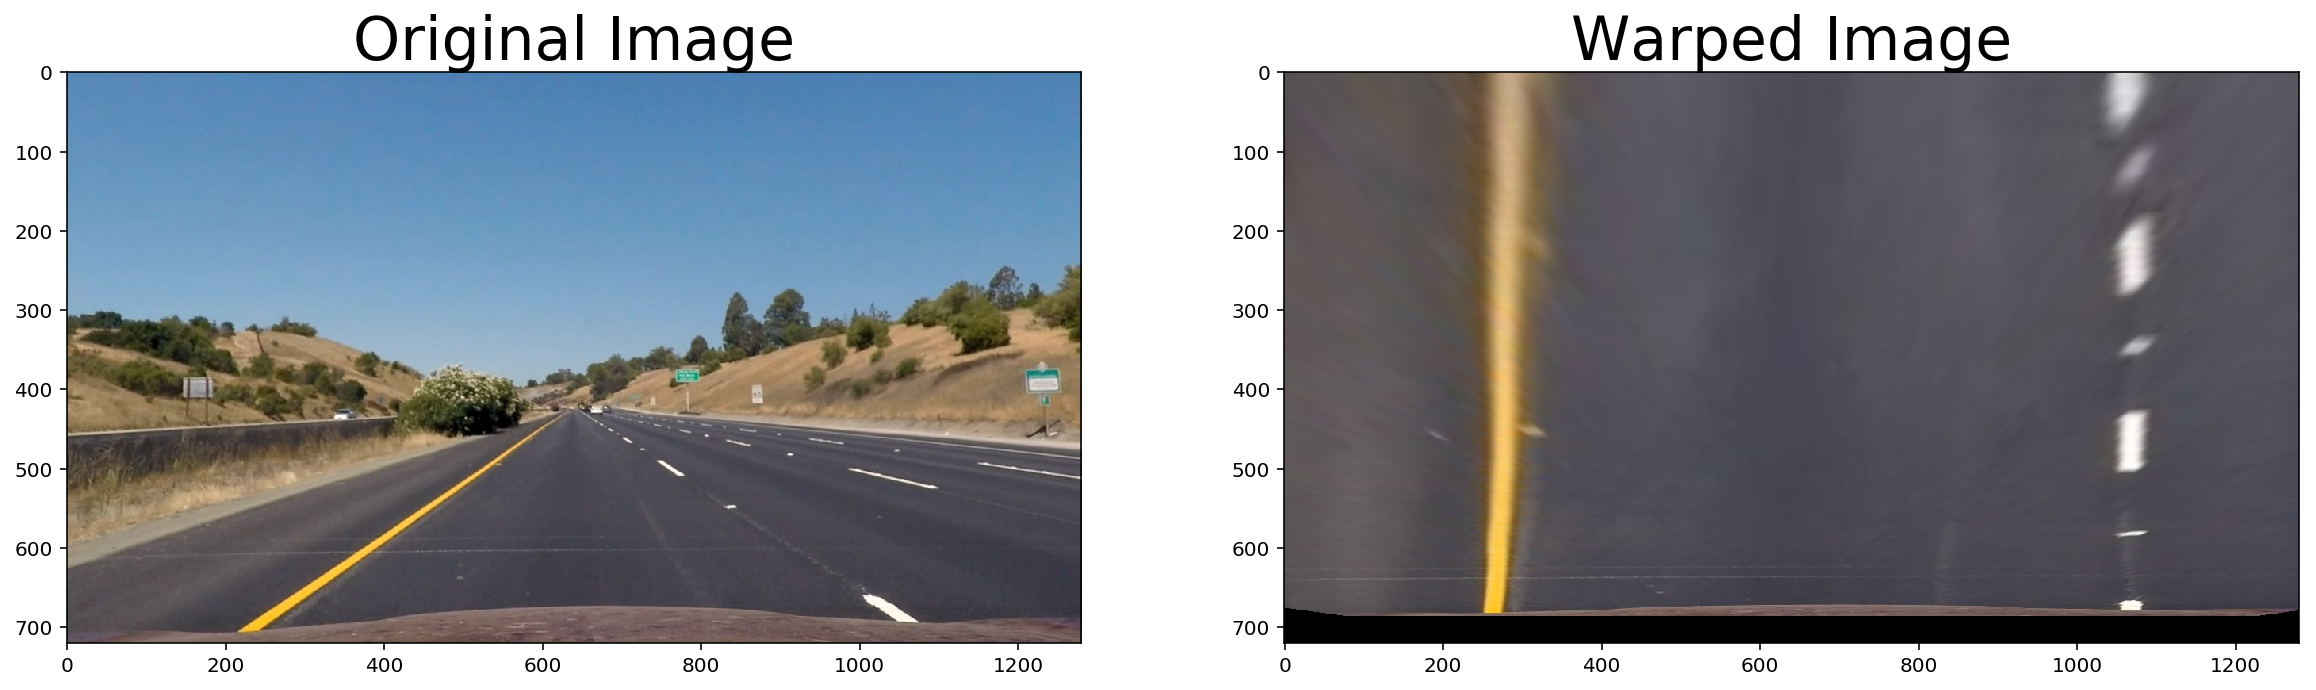

In [185]:
test_transform('test_images/straight_lines1.jpg')   

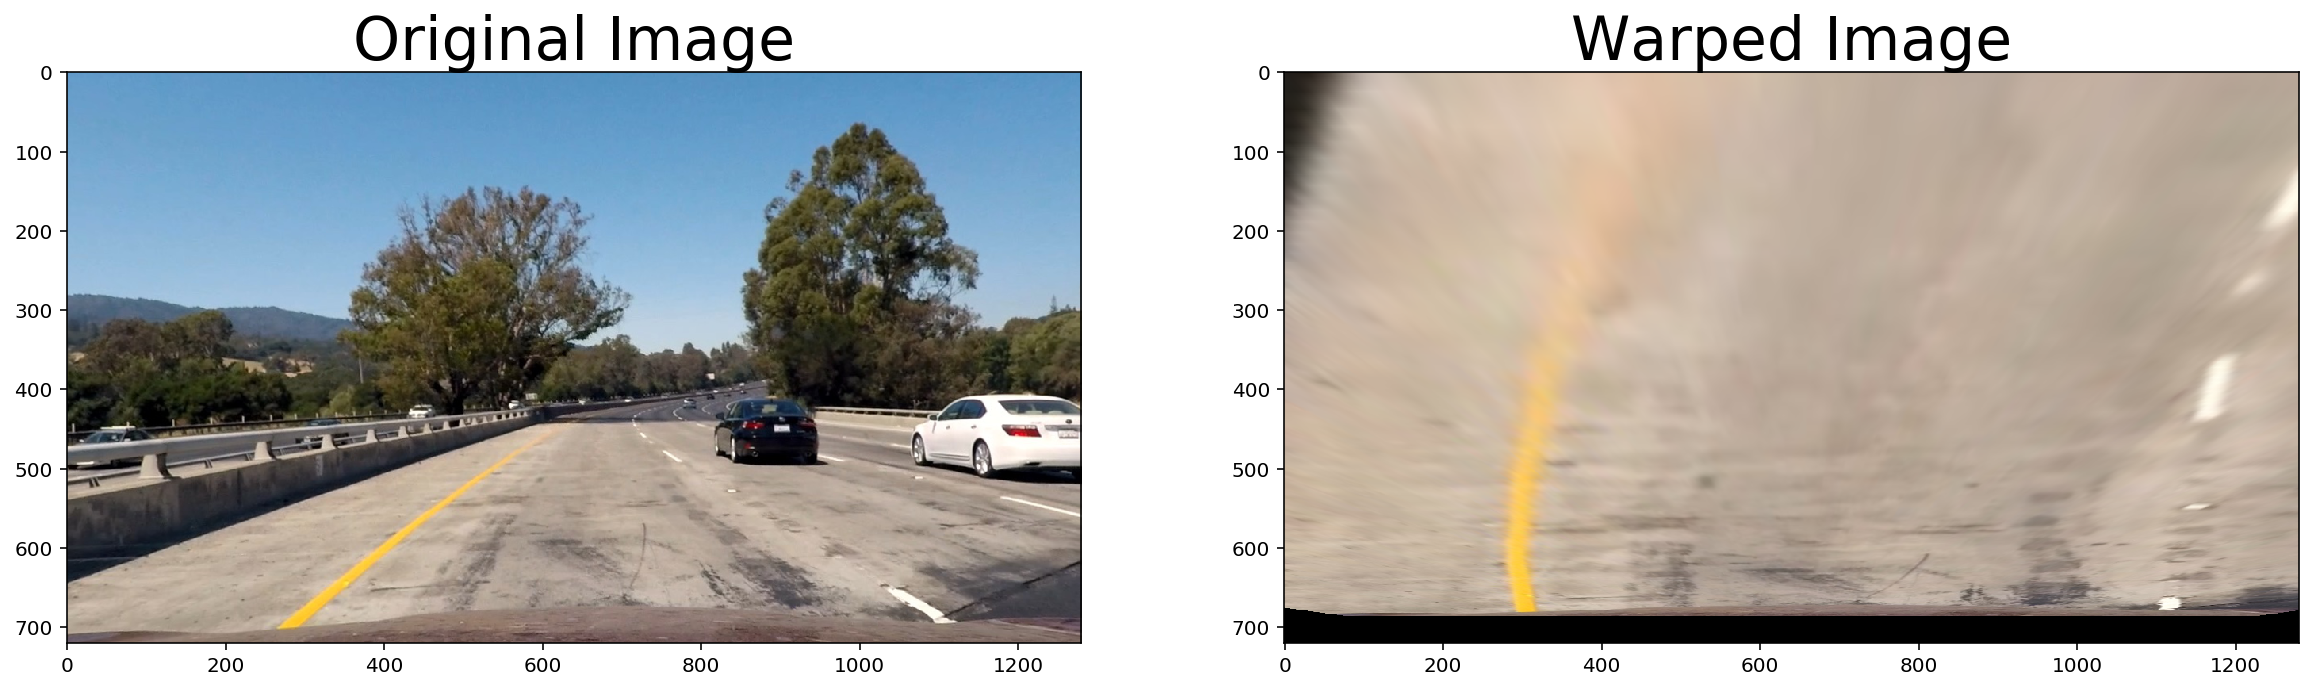

In [186]:
test_transform('test_images/test1.jpg')   

# Gradient and Color Masks

In [28]:
def gradient_axis_mask(img, axis='x', sobel_kernel=3, thresh=(0, 255)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    dx = 1 if axis == 'x' else 0
    dy = 1 if axis == 'y' else 0
    
    sobel = cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
 
    return grad_binary

def gradient_magnitude_mask(img, sobel_kernel=3, thresh=(0, 255)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.sqrt((sobelx)**2 + (sobely)**2)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return mag_binary


def gradient_direction_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) 

    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh_min) & (direction <= thresh_max)] = 1

    return dir_binary

def hls_mask(img,component='S', thresh=(0,180)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    H = img[:,:,0]
    L = img[:,:,1]
    S = img[:,:,2]

    if component == 'H':
        C = H
    elif component == 'L':
        C = L
    else:
        C = S

    binary = np.zeros_like(C)
    binary[(C >= thresh[0]) & (C <= thresh[1])] = 1
    
    return binary


def mask_conjunction(mask1,mask2):
    
    binary = np.zeros_like(mask1)
    binary[(mask1 == 1) & (mask2 == 1)] = 1
    
    return binary

def mask_disjunction(mask1,mask2):
    
    binary = np.zeros_like(mask1)
    binary[(mask1 == 1) | (mask2 == 1)] = 1
    
    return binary
    

In [255]:
def create_mask(image):
       
    yellow_hue_mask = hls_mask(image, component='H', thresh=(27 * 180 / 255, 34 * 180 / 255)) #yellow hue mask
    saturation_mask = hls_mask(image, component='S', thresh=(190, 255)) #saturation mask
    #white_hue_mask = hls_mask(image, component='H', thresh=(15 * 180 / 255, 16 * 180 / 255)) #white hue mask
    
    direction_mask = gradient_direction_mask(image, thresh=(0, np.pi / 10)) #vertical gradient
    magnitude_mask = gradient_magnitude_mask(image, thresh=(10, 100)) #magnitude gradient
    result = mask_conjunction(direction_mask,magnitude_mask)  
    result = mask_disjunction(saturation_mask,result)
    result = mask_disjunction(yellow_hue_mask,result)
    
    return result

def test_mask(file):
    
    img = cv2.imread(file)
    img = undistort(img)  
   
    mask = create_mask(img)
    mask = transform(mask)   
    #mask = reverse(mask)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(255 * mask, cmap='gray', vmin = 0, vmax = 255)
    ax2.set_title('Mask Image', fontsize=30) 

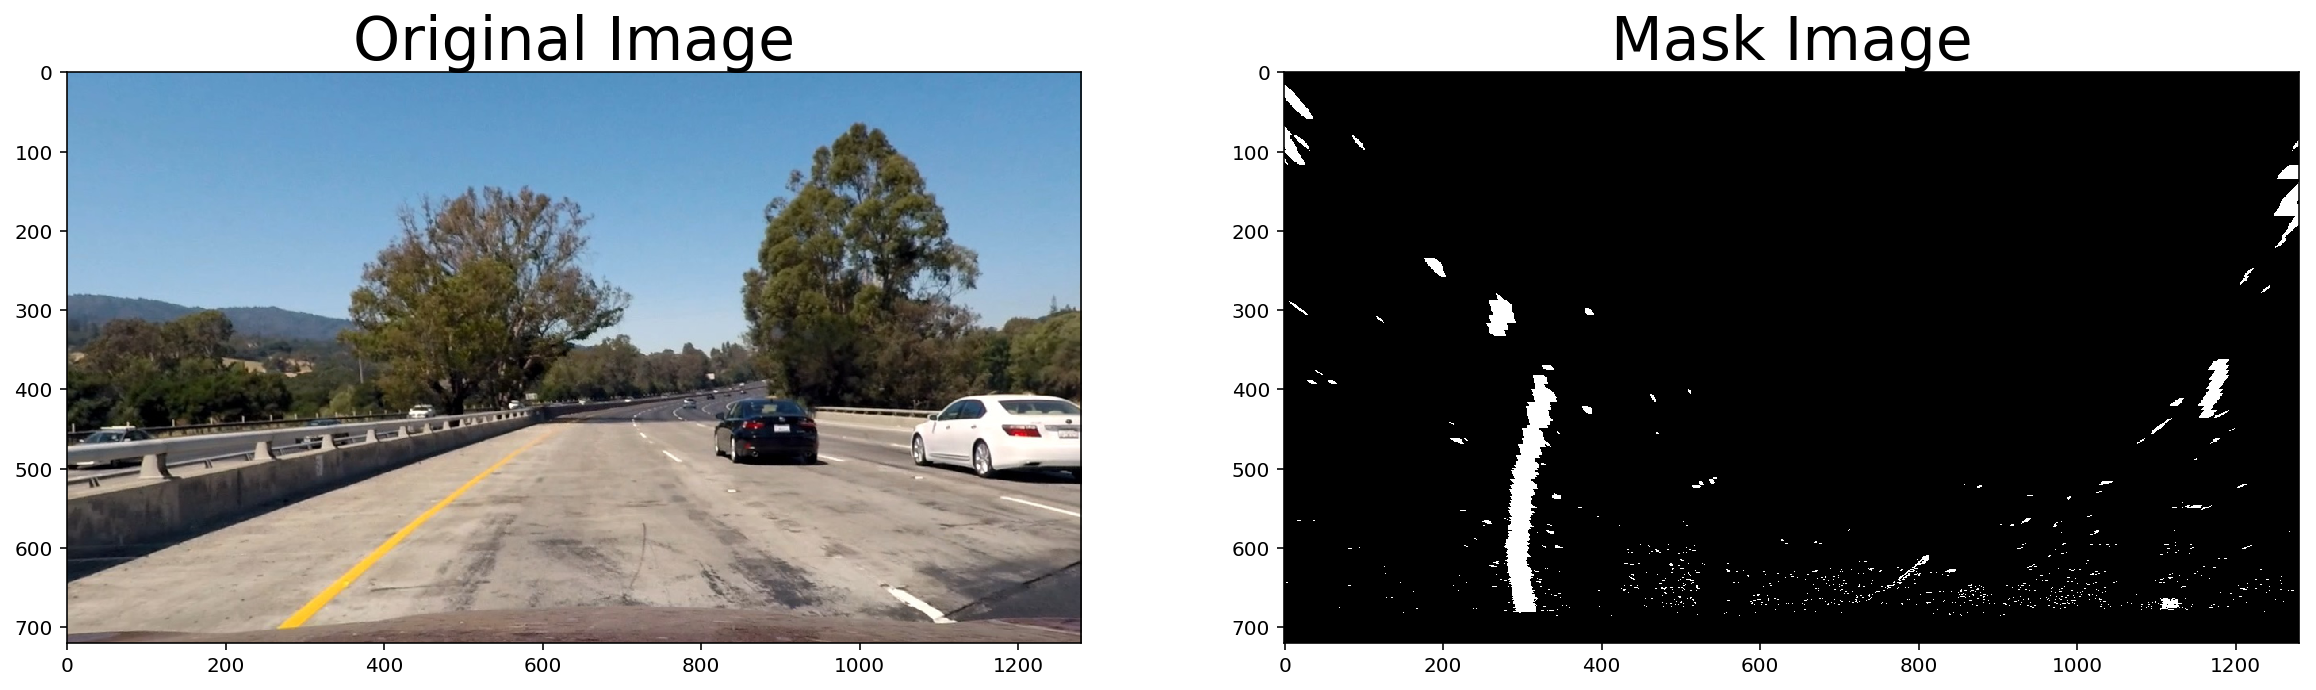

In [257]:
test_mask('test_images/test1.jpg')

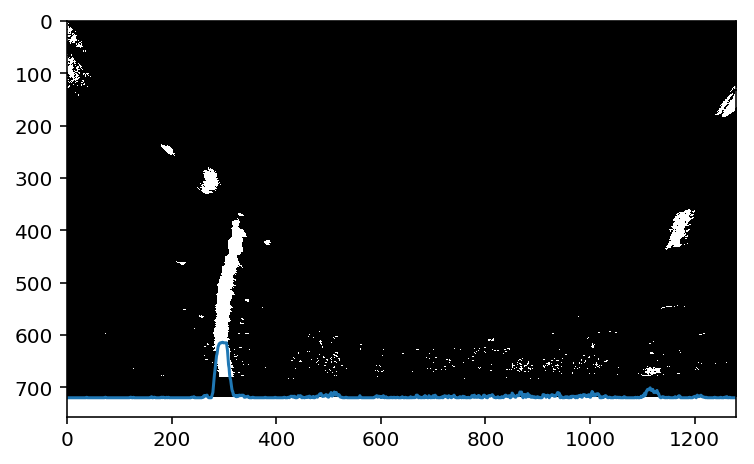

In [188]:
img = cv2.imread('test_images/test1.jpg')
img = undistort(img)  
warped = transform(img)       
mask = create_mask(warped)


start = int ((4/5) * mask.shape[0])
histogram = mask.shape[0] - np.sum(mask[start:,:], axis=0)
plt.imshow(255 * mask, cmap='gray', vmin = 0, vmax = 255)
plt.plot(histogram)
plt.show()



In [163]:
def sliding_windows_fit(
    binary_warped, 
    margin=100, # Set the width of the windows +/- margin  
    minpix=50, # Set minimum number of pixels found to recenter window
    nwindows=9 # Choose the number of sliding windows
    ):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin

    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds

In [270]:
def test_sliding_windows_fit(file):
    
    img = cv2.imread(file)
    img = undistort(img)  
    #warped = transform(img)       
    #binary_warped = create_mask(warped)
    
    binary_warped = create_mask(img)
    binary_warped = transform(binary_warped)       

    
    left_fit, right_fit, out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds = sliding_windows_fit(
        binary_warped, 
        minpix = 50, 
        margin = 100)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
   
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    ax1.imshow(out_img)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(720, 0)
    ax1.set_title('Sliding Windows', fontsize=30)
    
    ax2.imshow(255 * binary_warped, cmap='gray', vmin = 0, vmax = 255)
    ax2.set_title('Original', fontsize=30) 
    

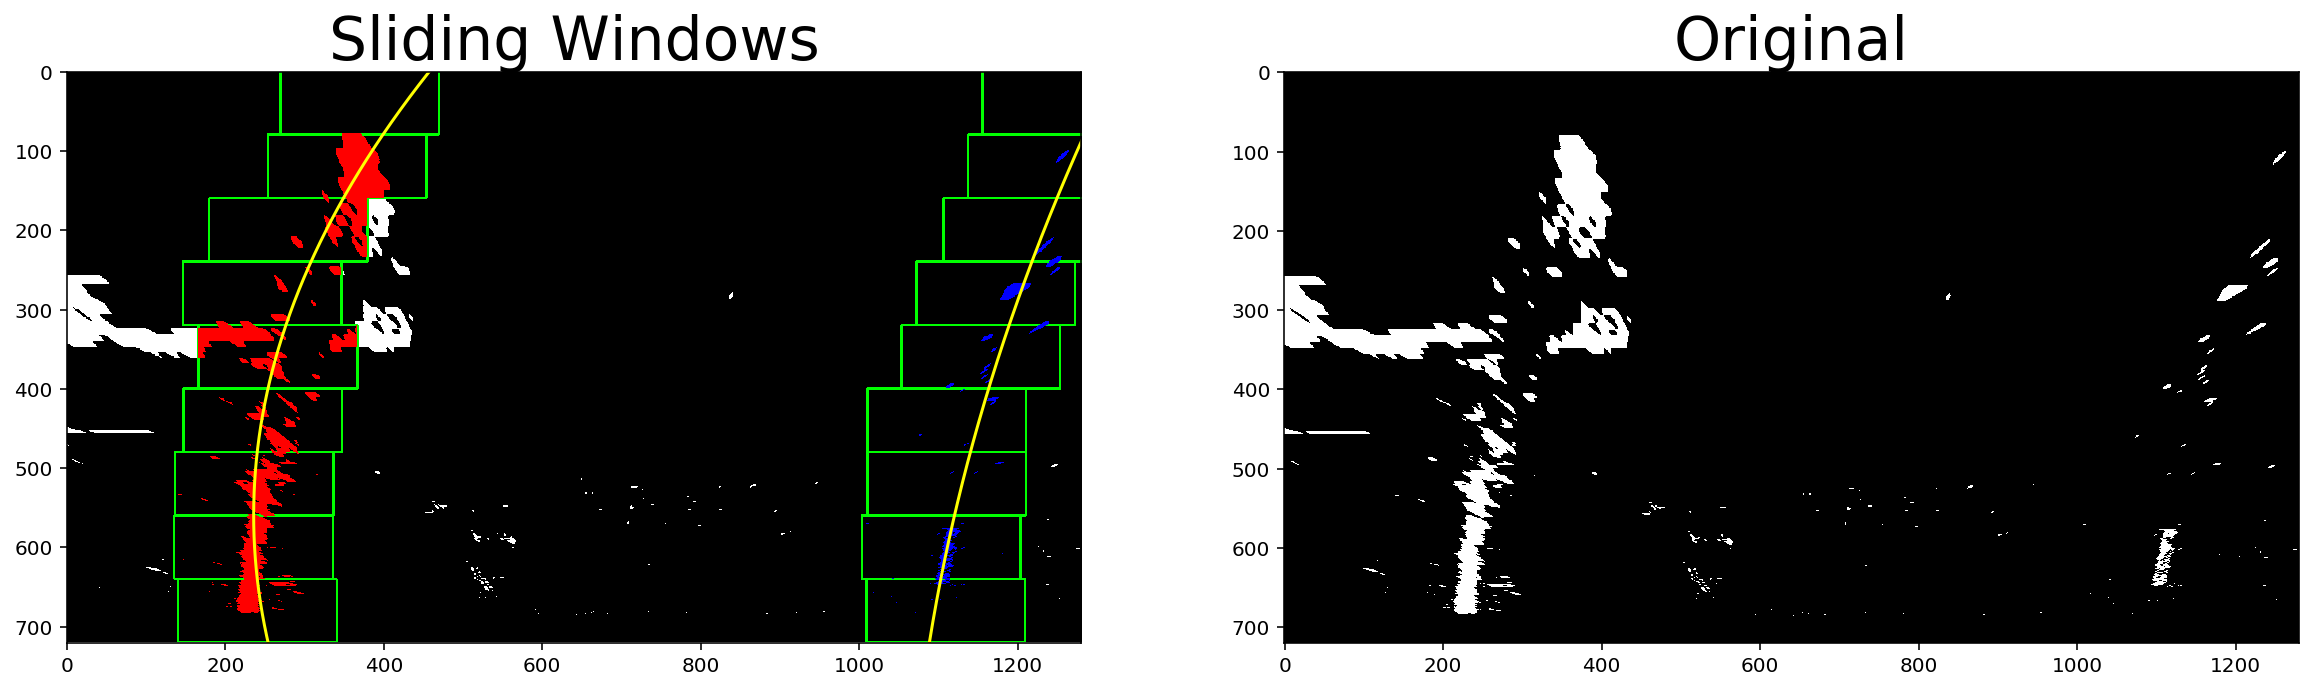

In [271]:
test_sliding_windows_fit('test_images/test5.jpg')

In [273]:
def fit(binary_warped, left_fit, right_fit, margin=100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

In [302]:
def test_fit(file):
    
    img = cv2.imread(file)
    img = undistort(img)  
    
    mask = create_mask(img)
    binary_warped = transform(mask)
    
    left_fit, right_fit, _, _, _, _, _ = sliding_windows_fit(
        binary_warped, 
        minpix = 50, 
        margin = 100)

    
    left_fit, right_fit = fit(
        binary_warped, 
        left_fit, 
        right_fit,
        margin = 100)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    margin = 100
    
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

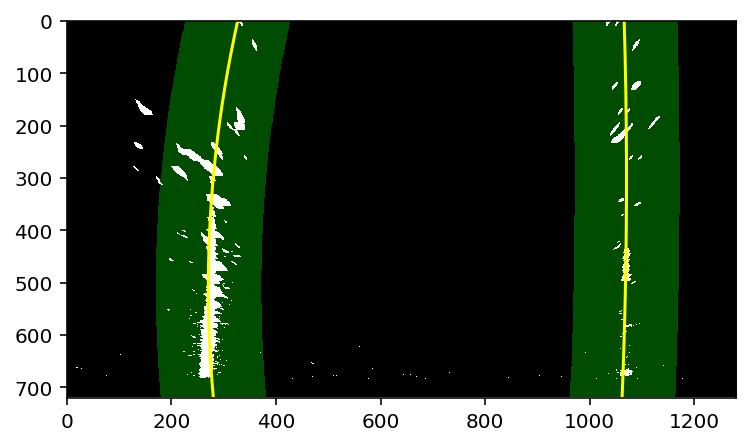

In [303]:
test_fit('test_images/straight_lines1.jpg')